In [2]:
# check if sum correct
# import pandas as pd

# # df_a['sum'] = df_a[u'p0_s_kls_elo'] + df_a[u'p1_s_kls_elo']
# # df_a[df_a['sum']<1][['p0_s_kls','p1_s_kls']]

In [11]:
# if you're going to do feature importance, do it with clf.coef_

In [2]:
def display(tup):
    return tup[0][0]/tup[1][0]

In [3]:
# can use np.where() to convert boolean index into indices

In [4]:
import sys
sys.path.insert(0,'/Users/jacobgollub/Desktop/college/research/pbp_explorations/scripts/sackmann')
import tennisGameProbability,tennisMatchProbability,tennisSetProbability,tennisTiebreakProbability
from tennisMatchProbability import matchProb
from sklearn import linear_model
from sklearn.metrics import log_loss, accuracy_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from sklearn.metrics import log_loss

df = pd.read_csv('../my_data/feature_df_pbp3_10_15_probs.csv')
del df['Unnamed: 0']
df['set_diff'] = df['sets_0'] - df['sets_1']
df['game_diff'] = df['games_0'] - df['games_1']
df['point_diff'] = df['points_0'] - df['points_1']
df['brkpoint_adv'] = df['up_break_point'] - df['down_break_point']
df['sv_points_pct_0'] = np.nan_to_num(np.divide(df['p0_swp'],df['p0_sp'].astype('float')))
df['sv_points_pct_1'] = np.nan_to_num(np.divide(df['p1_swp'],df['p1_sp'].astype('float')))
df['current_set'] = df['sets_0'] + df['sets_1'] + 1
df['final_set'] = df['current_set']==3

# df['third_set_I'] = (df['sets_0']+df['sets_1']) == 2
# df['games_left_0'], df['games_left_1'] = 0,0
# reg_ind, ext_ind = np.where((df['games_0']+df['games_1'])<10),\
#                     np.where((df['games_0']+df['games_1'])>=10)
# df.loc[ext_ind,'games_left_0'] = 7 - df.loc[ext_ind,'games_0']
# df.loc[reg_ind]['games_left_0'] = 6 - df.loc[reg_ind]['games_0']
# df.loc[ext_ind]['games_left_1'] = 7 - df.loc[ext_ind]['games_1']
# df.loc[reg_ind]['games_left_1'] = 6 - df.loc[reg_ind]['games_1']
# df['games_left_I_0'] = df['third_set_I'] * df['games_left_0']
# df['games_left_I_1'] = df['third_set_I'] * df['games_left_1']
df['third_set_I'] = (df['sets_0']+df['sets_1']) == 2
df['games_left_0'], df['games_left_1'] = 0,0
reg_ind, ext_ind = np.where((df['games_0']+df['games_1'])<10),\
                    np.where((df['games_0']+df['games_1'])>=10)
df['games_left_0'].loc[ext_ind] = 7 - df.loc[ext_ind]['games_0']
df['games_left_0'].loc[reg_ind] = 6 - df.loc[reg_ind]['games_0']
df['games_left_1'].loc[ext_ind] = 7 - df.loc[ext_ind]['games_1']
df['games_left_1'].loc[reg_ind] = 6 - df.loc[reg_ind]['games_1']
df['games_left_I_0'] = df['third_set_I'] * df['games_left_0']
df['games_left_I_1'] = df['third_set_I'] * df['games_left_1']

col_d = {'Clay':0,'Hard':1,'Grass':2}
df['surface_num'] = [col_d[surface] for surface in df['surface']]

match_df = pd.read_csv('../my_data/elo_pbp_with_surface_10_15.csv')
train_ids = set(match_df[match_df['match_year']<2014]['match_id'])
test_ids = set(match_df[match_df['match_year'].isin([2014])]['match_id'])
train_df, test_df = df[df['match_id'].isin(train_ids)], df[df['match_id'].isin(test_ids)]

/Users/jacobgollub/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
# match_df['diff'] = match_df['p0_s_kls_JS'] - match_df['p1_s_kls_JS']
# match_df['adj_diff'] = match_df['p0_s_kls_adj_JS'] - match_df['p1_s_kls_adj_JS']
# match_df['discrep'] = match_df['diff'] - match_df['adj_diff']

In [50]:
# match_df['discrep'] = match_df['match_prob_kls'] - match_df['match_prob_adj_kls']
# sub = match_df[match_df['match_year']==2014]
# sub = sub[sub['tny_name']=='US Open']
# sub = sub[(sub['discrep']>.07) | (sub['discrep']<-.07)]
# sub = sub[(sub['p0_52_svpt']>200) & (sub['p1_52_svpt']>200)]
# #sub[['p0_name','p1_name','p0_52_svpt','p1_52_svpt','elo_prob','match_prob_kls_JS','match_prob_adj_kls','diff','adj_diff','discrep']]
# sub[['p0_name','p1_name','p0_52_svpt','p1_52_svpt','match_prob_kls','match_prob_adj_kls','elo_prob','tny_stats']]

# # sub[['p0_s_kls','p1_s_kls', u'elo_diff_538', u'sf_elo_diff_538',
# #        u'p0_elo', u'p1_elo','p0_s_kls','p1_s_kls']]

## Logistic Regression

In [5]:
scores = ['set_diff','game_diff','point_diff']
break_feats = ['brkpoint_adv', u'break_adv']
point_rates = [u'sv_points_pct_0', u'sv_points_pct_1']
cols = ['lead_margin','elo_diff','sf_elo_diff']+scores+break_feats+point_rates
cols2 = cols + ['games_left_I_0','games_left_I_1']
# cols2 = ['sets_0','sets_1','games_0','games_1','points_0','points_1',u'up_break_point', 
#          u'down_break_point', u'break_adv',u'sv_points_pct_0', u'sv_points_pct_1',
#         'lead_margin','elo_diff','sf_elo_diff']

# for MLP, I would consider grid search over alpha, batch_size, and hidden_layer_sizes...
#models = [linear_model.LogisticRegression(fit_intercept = True)]
clf = linear_model.LogisticRegression(fit_intercept = True)
model_hparams = {'LogisticRegression':{'C':[100]}}
baseline = ['lead_margin','elo_diff','sf_elo_diff']
column_lists = [baseline,scores,cols,cols2]

for columns in column_lists:
    print columns
    Xtrain, ytrain = train_df[columns],train_df['winner']
    Xtest, ytest = test_df[columns],test_df['winner']
    model_name = clf.__str__().split('(')[0]
    print model_name
    setattr(clf,'C',100)
#         best_hyper_p = cross_validate(val_df,clf,columns,'winner',model_hparams[model_name],n_splits=5)
#         for key in best_hyper_p.keys():
#             setattr(clf,key,best_hyper_p[key])
    clf.fit(Xtrain,ytrain)

    lr_probs_train,lr_probs_test = clf.predict_proba(Xtrain)[:,1],clf.predict_proba(Xtest)[:,1]
    train_loss, test_loss = log_loss(ytrain,lr_probs_train,labels=[0,1]), \
                            log_loss(ytest,lr_probs_test,labels=[0,1])
    train_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print train_loss, test_loss
    print train_accuracy, test_accuracy
    print display(calibration_curve(ytest, lr_probs_test,n_bins=1)), '\n'
print 'final model coef: ', clf.coef_

['lead_margin', 'elo_diff', 'sf_elo_diff']
LogisticRegression
0.491832525039 0.504588555367
0.760159190548 0.75239250873
0.993448975542 

['set_diff', 'game_diff', 'point_diff']
LogisticRegression
0.530244338488 0.540222836241
0.723727174885 0.71355946669
1.00589768351 

['lead_margin', 'elo_diff', 'sf_elo_diff', 'set_diff', 'game_diff', 'point_diff', 'brkpoint_adv', u'break_adv', u'sv_points_pct_0', u'sv_points_pct_1']
LogisticRegression
0.475065984674 0.487354489298
0.768217527986 0.763105455922
0.993373113107 

['lead_margin', 'elo_diff', 'sf_elo_diff', 'set_diff', 'game_diff', 'point_diff', 'brkpoint_adv', u'break_adv', u'sv_points_pct_0', u'sv_points_pct_1', 'games_left_I_0', 'games_left_I_1']
LogisticRegression
0.472233147723 0.486218931679
0.769360683948 0.762860546149
0.992343909613 

final model coef:  [[ 0.74396294  0.00231915  0.00196201  0.71913626  0.11594389  0.13206485
   0.14205549  0.59035587  0.08667854 -0.05840816 -0.45949537  0.46469745]]


## Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from helper_functions import *
# try with smaller df first
val_df = train_df
cols = ['match_id','final_set','surface_num','elo_diff','set_diff','break_adv','point_diff','winner']


hyper_params = {'max_features':[2,3,6],'min_samples_split':[100,500,1000]}
clf = GridSearchCV(RandomForestClassifier(),hyper_params,scoring='neg_log_loss',cv=5)
clf.fit(val_df[cols[:-1]],val_df[cols[-1]])

rf_preds = clf.predict(test_df[cols[:-1]])
rf_probs = clf.predict_proba(test_df[cols[:-1]])[:,1]
print accuracy_score(rf_preds,test_df['winner'])
print log_loss(test_df['winner'],rf_probs)

0.691610355973
0.587879056303


In [4]:
# set probs and indices for sets, surface
df['lr_probs'] = 0
df['lr_probs'].loc[test_df.index] = lr_probs_test
df['lr_probs'].loc[train_df.index] = lr_probs_train
# df['rf_probs'] = 0
# df['rf_probs'].loc[test_df.index] = rf_probs

df['sets_completed'] = df['sets_0'] + df['sets_1']
#df.to_csv('../my_data/feature_df_pbp3_10_15_probs.csv')

/Users/jacobgollub/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [1]:
# START HERE for graphs, metrics
import sys
sys.path.insert(0,'/Users/jacobgollub/Desktop/college/research/pbp_explorations/scripts/sackmann')
import tennisGameProbability,tennisMatchProbability,tennisSetProbability,tennisTiebreakProbability
from tennisMatchProbability import matchProb
from sklearn import linear_model
from sklearn.metrics import log_loss, accuracy_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss

df = pd.read_csv('../my_data/feature_df_pbp3_10_15_probs.csv')
del df['Unnamed: 0']

match_df = pd.read_csv('../my_data/elo_pbp_with_surface_10_15.csv')
train_ids = set(match_df[match_df['match_year']<2014]['match_id'])
test_ids = set(match_df[match_df['match_year'].isin([2014])]['match_id'])
train_df, test_df = df[df['match_id'].isin(train_ids)], df[df['match_id'].isin(test_ids)]

In [2]:
def display(tup):
    return tup[0][0]/tup[1][0]

## Visualizing Matches

In [ ]:
m_id1 = 10667
m_id2 = 836
m_id3 = 1
m_id4 = 6310
m_id5 = 9224

def set_ind(df):
    return df[(df['games_0']==0) & (df['games_1']==0) & 
              (df['points_0']==0) & (df['points_1']==0)].index[1:]

In [3]:
match3 = df[df['match_id']==m_id3].reset_index()
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
line1 = ax.plot(np.arange(len(match3)),match3['lr_probs'],'r-',linewidth=2.4)
line2 = ax.plot(np.arange(len(match3)),match3['klaassen_prob_a_300'],'b-',linewidth=2.4)


fig.suptitle('Julian Reister vs. Richard Gasquet 7-6 3-6 3-6 (ATP Montpellier 2010)')
ax.set_ylabel('Reister win probability')
ax.set_xlabel('# points played')
ax.set_ylim([0,1])
ax.legend((line1[0], line2[0]), ('LR 3) win probability', 'KM Logit elo win probability'))
plt.savefig('writing/photos/reister_gasquet')
# #fig.show()

NameError: name 'df' is not defined

In [30]:
match3[['klaassen_prob_a_300','lr_probs',
        'games_0','games_1','points_0','points_1','server']].loc[140:]

,klaassen_prob_a_300,lr_probs,games_0,games_1,points_0,points_1,server
140,0.224180,0.221810,1.0,0.0,0.0,1.0,0.0
141,0.215289,0.194742,1.0,0.0,0.0,2.0,0.0
142,0.210475,0.170254,1.0,0.0,0.0,3.0,0.0
143,0.208242,0.196835,1.0,1.0,0.0,0.0,1.0
144,0.173311,0.172115,1.0,1.0,0.0,1.0,1.0
145,0.201574,0.196818,1.0,1.0,1.0,1.0,1.0
146,0.158070,0.172101,1.0,1.0,1.0,2.0,1.0
147,0.194647,0.196803,1.0,1.0,2.0,2.0,1.0
148,0.134560,0.155428,1.0,1.0,2.0,3.0,1.0
149,0.038601,0.091529,1.0,2.0,0.0,0.0,0.0


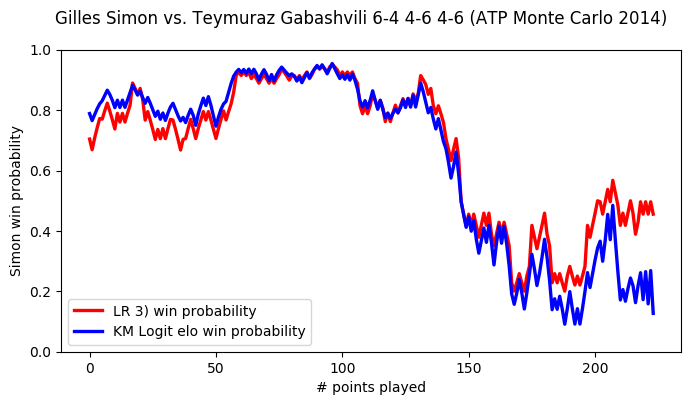

In [31]:
match4 = df[df['match_id']==m_id4].reset_index()
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
line1 = ax.plot(np.arange(len(match4)),match4['lr_probs'],'r-',linewidth=2.4)
line2 = ax.plot(np.arange(len(match4)),match4['klaassen_prob_a_300'],'b-',linewidth=2.4)


fig.suptitle('Gilles Simon vs. Teymuraz Gabashvili 6-4 4-6 4-6 (ATP Monte Carlo 2014)')
ax.set_ylabel('Simon win probability')
ax.set_xlabel('# points played')
ax.set_ylim([0,1])
ax.legend((line1[0], line2[0]), ('LR 3) win probability', 'KM Logit elo win probability'))
plt.savefig('writing/photos/simon_gabashvili')

In [24]:
# # df_b = pd.read_csv('../my_data/feature_df_pbp5_10_15_probs.csv')
# match1 = df_b[df_b['match_id']==m_id1]
# match1 = match1.reset_index()
# m1_probs = match1['klaassen_prob_a_300'].append(pd.Series([0]))
# fig = plt.figure(figsize=(8,4))
# ax = fig.add_subplot(1,1,1)
# ax.plot(np.arange(len(m1_probs)),1-m1_probs,'b-',linewidth=2.4)
# fig.suptitle('Roger Federer d. Rafael Nadal 6-4 3-6 6-1 3-6 6-3')
# ax.set_ylabel('Federer win probability')
# ax.set_xlabel('# points played')
# ax.set_ylim([0,1])

# x_s = set_ind(match1)
# ax.annotate('Federer wins \nfirst set 6-4', xy=(x_s[0], 1-m1_probs[x_s[0]]-.01), xytext=(x_s[0]-35, 1-m1_probs[x_s[0]]-.42),
#             arrowprops=dict(arrowstyle="-",facecolor='black'))
# ax.annotate('Nadal wins \nsecond set 6-3', xy=(x_s[1], 1-m1_probs[x_s[1]]), xytext=(x_s[1]-35, 1-m1_probs[x_s[1]]-.4),
#             arrowprops=dict(arrowstyle="-",facecolor='black'))
# ax.annotate('Federer wins \nthird set 6-1', xy=(x_s[2], 1-m1_probs[x_s[2]]-.005), xytext=(x_s[2]-35, 1-m1_probs[x_s[2]]-.3),
#             arrowprops=dict(arrowstyle="-",facecolor='black'))
# ax.annotate('Nadal wins \nfourth set 6-3', xy=(x_s[3]-1, 1-m1_probs[x_s[3]]), xytext=(x_s[3]-60, 1-m1_probs[x_s[3]]-.24),
#             arrowprops=dict(arrowstyle="-",facecolor='black'))
# # ax.annotate('Federer wins first set 6-4', xy=(50,.3), xytext=(50, .9),
# #             arrowprops=dict(facecolor='black', shrink=0.05))
# plt.savefig('writing/photos/federer_nadal_ao_17')
# #fig.show()

In [25]:
# match2 = df_b[df_b['match_id']==m_id2]
# m2_probs = match2['klaassen_prob_a_300'].append(pd.Series([0.]))
# low_pt = np.argmax(m2_probs)
# fig = plt.figure(figsize=(8,4))
# ax = fig.add_subplot(1,1,1)
# ax.plot(np.arange(len(m2_probs)),1-m2_probs,'b-',linewidth=2.4)
# fig.suptitle('Novak Djokovic d. Roger Federer 6-7 4-6 6-3 6-2 7-5')
# ax.set_ylabel('Djokovic win probability')
# ax.set_xlabel('# points played')
# ax.set_ylim([0,1])

# x_s = set_ind(match2)
# ax.annotate('Federer wins \nfirst set 7-6', xy=(x_s[0], 1-m2_probs[x_s[0]]-.01), xytext=(x_s[0]-35, 1-m2_probs[x_s[0]]-.22),
#             arrowprops=dict(arrowstyle="-",facecolor='black'))
# ax.annotate('Federer wins \nsecond set 6-4', xy=(x_s[1], 1-m2_probs[x_s[1]]), xytext=(x_s[1]-35, 1-m2_probs[x_s[1]]-.15),
#             arrowprops=dict(arrowstyle="-",facecolor='black'))
# ax.annotate('Djokovic wins \nthird set 6-3', xy=(x_s[2], 1-m2_probs[x_s[2]]+.005), xytext=(x_s[2]-50, 1-m2_probs[x_s[2]]+.1),
#             arrowprops=dict(arrowstyle="-",facecolor='black'))
# ax.annotate('Djokovic wins \nfourth set 6-2', xy=(x_s[3]-1, 1-m2_probs[x_s[3]]), xytext=(x_s[3]-35, 1-m2_probs[x_s[3]]+.1),
#             arrowprops=dict(arrowstyle="-",facecolor='black'))
# ax.annotate('Djokovic returning \nat 3-5 15-40 \n(p='+str(1-round(m2_probs[low_pt],3))+')', xy=(low_pt-1,1-m2_probs[low_pt]), 
#             xycoords='data',
#             xytext=(low_pt-90, 1-m2_probs[low_pt]+.14), arrowprops=dict(arrowstyle="-",facecolor='black'))
# plt.savefig('writing/photos/djokovic_federer_uso_11')
#fig.show()

In [102]:
#match_df[match_df['match_id']==m_id5]['pbp'][9224]

In [26]:
# df_b = pd.read_csv('../my_data/feature_df_pbp5_11_2_probs.csv')
# match3 = df_b[df_b['match_id']==m_id5]
# match3 = match3.reset_index()
# m3_probs = match3['klaassen_prob_a_300'].append(pd.Series([1]))
# fig = plt.figure(figsize=(8,4))
# ax = fig.add_subplot(1,1,1)
# ax.plot(np.arange(len(m3_probs)),m3_probs,'b-',linewidth=2.4)
# fig.suptitle('Stanislas Wawrinka d. Novak Djokovic 4-6 6-4 6-3 6-4')
# ax.set_ylabel('Wawrinka win probability')
# ax.set_xlabel('# points played')
# ax.set_ylim([0,1])

# x_s = set_ind(match3)
# ax.annotate('Djokovic wins \nfirst set 6-4', xy=(x_s[0], m3_probs[x_s[0]]+.01), xytext=(x_s[0]-35, m3_probs[x_s[0]]+.18),
#             arrowprops=dict(arrowstyle="-",facecolor='black'))
# ax.annotate('Wawinka wins \nsecond set 6-4', xy=(x_s[1], m3_probs[x_s[1]]), xytext=(x_s[1]-35, m3_probs[x_s[1]]+.18),
#             arrowprops=dict(arrowstyle="-",facecolor='black'))
# ax.annotate('Wawinka wins \nthird set 6-3', xy=(x_s[2], m3_probs[x_s[2]]), xytext=(x_s[2]-35, 1-m3_probs[x_s[2]]),
#             arrowprops=dict(arrowstyle="-",facecolor='black'))
# plt.savefig('writing/photos/wawrinka_djokovic_fo_15')
# #fig.show()

## Point-based

In [36]:
# alphas = [300]
# n = len(test_df)
# for alpha in alphas:
#     #a,b = calibration_curve(test_df['winner'], , n_bins=1)
#     print 'klaassen score, a='+str(alpha)+': ',log_loss(test_df['winner'][:n],
#            test_df['klaassen_prob_a_'+str(alpha)][:n],labels=[0,1]), \
#            accuracy_score(test_df['winner'][:n],test_df['klaassen_prob_a_'+str(alpha)][:n]>=.5),\
#            display(calibration_curve(test_df['winner'], test_df['klaassen_prob_a_'+str(alpha)], n_bins=1))

 klaassen score, a=300:  0.481394942656 0.763086902151 1.00322148017


In [7]:
from sklearn.metrics import log_loss,accuracy_score

n = len(test_df)
# a=400 works the best
print 'sackmann score: ',log_loss(test_df['winner'][:n],test_df['sackmann_prob'][:n],labels=[0,1]),\
        accuracy_score(test_df['winner'][:n],test_df['sackmann_prob'][:n]>=.5), \
        display(calibration_curve(test_df['winner'], test_df['sackmann_prob'], n_bins=1))
# print 'klaassen score: ',log_loss(test_df['winner'][:n],test_df['klaassen_prob'][:n],labels=[0,1]),\
#         accuracy_score(test_df['winner'][:n],test_df['klaassen_prob'][:n]>=.5)
print 'klaassen score JS: ',log_loss(test_df['winner'][:n],test_df['klaassen_prob_JS'][:n],labels=[0,1]),\
        accuracy_score(test_df['winner'][:n],test_df['klaassen_prob_JS'][:n]>=.5), \
        display(calibration_curve(test_df['winner'], test_df['klaassen_prob_JS'], n_bins=1))
# print 'klaassen score adj: ',log_loss(test_df['winner'][:n],test_df['klaassen_prob_adj'][:n],labels=[0,1]),\
#         accuracy_score(test_df['winner'][:n],test_df['klaassen_prob_adj'][:n]>=.5)
print 'klaassen score adj JS: ',log_loss(test_df['winner'][:n],test_df['klaassen_prob_adj_JS'][:n],labels=[0,1]),\
        accuracy_score(test_df['winner'][:n],test_df['klaassen_prob_adj_JS'][:n]>=.5), \
        display(calibration_curve(test_df['winner'], test_df['klaassen_prob_adj_JS'], n_bins=1))
print 'klaassen score elo: ',log_loss(test_df['winner'][:n],test_df['klaassen_prob_elo'][:n],labels=[0,1]),\
        accuracy_score(test_df['winner'][:n],test_df['klaassen_prob_elo'][:n]>=.5), \
        display(calibration_curve(test_df['winner'], test_df['klaassen_prob_elo'], n_bins=1))
print 'klaassen score logit elo: ',log_loss(test_df['winner'][:n],test_df['klaassen_prob_logit_elo'][:n],labels=[0,1]),\
        accuracy_score(test_df['winner'][:n],test_df['klaassen_prob_logit_elo'][:n]>=.5),\
        display(calibration_curve(test_df['winner'], test_df['klaassen_prob_logit_elo'], n_bins=1))
# print 'best score of both: ',log_loss(test_df['winner'][:n],best_prob[:n],labels=[0,1]),\
#         accuracy_score(test_df['winner'][:n],best_prob[:n]>=.5)

alphas = [100,200,300,400,500]
for alpha in alphas:
    #a,b = calibration_curve(test_df['winner'], , n_bins=1)
    print 'klaassen score, a='+str(alpha)+': ',log_loss(test_df['winner'][:n],
           test_df['klaassen_prob_a_'+str(alpha)][:n],labels=[0,1]), \
           accuracy_score(test_df['winner'][:n],test_df['klaassen_prob_a_'+str(alpha)][:n]>=.5),\
           display(calibration_curve(test_df['winner'], test_df['klaassen_prob_a_'+str(alpha)], n_bins=1))
           

sackmann score:  0.537986468952 0.715374025463 1.03958598939
klaassen score JS:  0.500931089767 0.749204970926 1.00174213356
klaassen score adj JS:  0.497598305198 0.758927146764 0.991936303148
klaassen score elo:  0.486318707603 0.761773295187 1.00002394451
klaassen score logit elo:  0.481170986748 0.765161213713 0.995634025848
klaassen score, a=100:  0.481358691621 0.761558071447 1.00454092148
klaassen score, a=200:  0.477324046726 0.764196417638 1.00096435753
klaassen score, a=300:  0.477331552957 0.765061023352 0.999442134319
klaassen score, a=400:  0.477730306789 0.765465495553 0.998596726517
klaassen score, a=500:  0.47812363198 0.765602793456 0.998058592214


In [8]:
zero_set_ind = test_df['sets_completed'] == 0
one_set_ind = test_df['sets_completed'] == 1
two_set_ind = test_df['sets_completed'] == 2
hard_ind = test_df['surface'] == 'Hard'
clay_ind = test_df['surface'] == 'Clay'
grass_ind = test_df['surface'] == 'Grass'

# to do: see how 2nd/3rd set performance is improved by beta experiments
# tuples hold log loss, and uncertainty of each subset
columns = ['klaassen_prob_JS','klaassen_prob_a_300','lr_probs','rf_probs']
indices = [zero_set_ind, one_set_ind, two_set_ind]
set_tuples = [],[]
set_tuples_a = [],[]

for col in columns:
    l_scores = [log_loss(test_df['winner'][ind],test_df[col][ind],labels=[0,1]) for ind in indices]
    a_scores = [accuracy_score(test_df['winner'][ind],test_df[col][ind]>.5) for ind in indices]
    set_tuples[0].append(l_scores)
    set_tuples_a[0].append(a_scores)

In [9]:
import math
def s_d(winners, probs):
    log_ls = [math.log(prob) if winner else math.log(1-prob) for prob in probs for winner in winners]
    return np.std(log_ls)

In [10]:
indices = [hard_ind, clay_ind, grass_ind]
surface_tuples = []
surface_tuples_a = []

for col in columns:
    l_scores = [log_loss(test_df['winner'][ind],test_df[col][ind],labels=[0,1]) for ind in indices]
    #l_sds = [s_d(test_df['winner'][ind], test_df[col][ind]) for ind in indices]
    a_scores = [accuracy_score(test_df['winner'][ind],test_df[col][ind]>.5) for ind in indices]
    surface_tuples.append(l_scores)
    surface_tuples_a.append(a_scores)

In [ ]:
# NOW: calculate uncertainty for each one

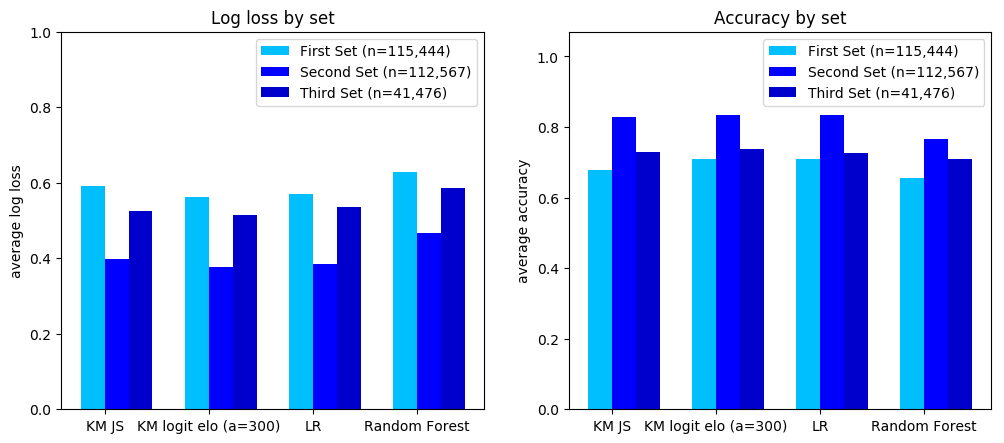

In [20]:
N = 4
first_set = [a[0] for a in set_tuples[0]]
second_set = [a[1] for a in set_tuples[0]]
third_set = [a[2] for a in set_tuples[0]]

ind = np.arange(N)  # the x locations for the groups
width = 0.23     # the width of the bars
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,5)

# other color scheme: b,r,g
rects1 = ax[0].bar(ind, first_set, width, color='#00BFFF')
rects2 = ax[0].bar(ind + width, second_set, width, color='#0000FF')
rects3 = ax[0].bar(ind + width + width, third_set, width, color='#0000CD')

# add some text for labels, title and axes ticks
ax[0].set_ylabel('average log loss')
ax[0].set_title('Log loss by set')
ax[0].set_ylim([0,1])
ax[0].set_xticks(ind + width / 2)
ax[0].set_xticklabels(('KM JS','KM logit elo (a=300)','LR','Random Forest'))
ax[0].legend((rects1[0], rects2[0], rects3[0]), ('First Set (n=115,444)', 'Second Set (n=112,567)', 'Third Set (n=41,476)'))

first_set = [a[0] for a in set_tuples_a[0]]
second_set = [a[1] for a in set_tuples_a[0]]
third_set = [a[2] for a in set_tuples_a[0]]

rects1 = ax[1].bar(ind, first_set, width, color='#00BFFF')
rects2 = ax[1].bar(ind + width, second_set, width, color='#0000FF')
rects3 = ax[1].bar(ind + width + width, third_set, width, color='#0000CD')

# add some text for labels, title and axes ticks
ax[1].set_ylabel('average accuracy')
ax[1].set_title('Accuracy by set')
ax[1].set_ylim([0,1.07])
ax[1].set_xticks(ind + width / 2)
ax[1].set_xticklabels(('KM JS','KM logit elo (a=300)','LR','Random Forest'))
ax[1].legend((rects1[0], rects2[0], rects3[0]), ('First Set (n=115,444)', 'Second Set (n=112,567)', 'Third Set (n=41,476)'))
plt.savefig('writing/photos/set_performance3')
plt.show()

In [16]:
sum(hard_ind)

152521

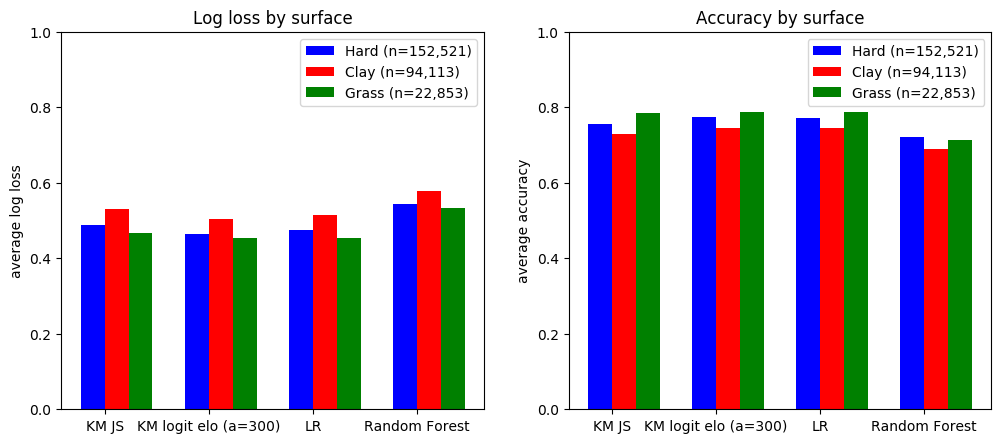

In [22]:
import numpy as np
import matplotlib.pyplot as plt

N = 4
first_set = [a[0] for a in surface_tuples]
second_set = [a[1] for a in surface_tuples]
third_set = [a[2] for a in surface_tuples]

ind = np.arange(N)  # the x locations for the groups
width = 0.23     # the width of the bars
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,5)

rects1 = ax[0].bar(ind, first_set, width, color='b')
rects2 = ax[0].bar(ind + width, second_set, width, color='r')
rects3 = ax[0].bar(ind + width + width, third_set, width, color='g')

# add some text for labels, title and axes ticks
ax[0].set_ylabel('average log loss')
ax[0].set_title('Log loss by surface')
ax[0].set_ylim([.3,1])
ax[0].set_ylim([0,1])
ax[0].set_xticks(ind + width / 2)
ax[0].set_xticklabels(('KM JS','KM logit elo (a=300)','LR','Random Forest'))
ax[0].legend((rects1[0], rects2[0], rects3[0]), ('Hard (n=152,521)', 'Clay (n=94,113)', 'Grass (n=22,853)'))

first_set = [a[0] for a in surface_tuples_a]
second_set = [a[1] for a in surface_tuples_a]
third_set = [a[2] for a in surface_tuples_a]

rects1 = ax[1].bar(ind, first_set, width, color='b')
rects2 = ax[1].bar(ind + width, second_set, width, color='r')
rects3 = ax[1].bar(ind + width + width, third_set, width, color='g')

# add some text for labels, title and axes ticks
ax[1].set_ylabel('average accuracy')
ax[1].set_title('Accuracy by surface')
ax[1].set_ylim([.5,1.07])
ax[1].set_ylim([0,1])
ax[1].set_xticks(ind + width / 2)
ax[1].set_xticklabels(('KM JS','KM logit elo (a=300)','LR','Random Forest'))
ax[1].legend((rects1[0], rects2[0], rects3[0]), ('Hard (n=152,521)', 'Clay (n=94,113)', 'Grass (n=22,853)'))
plt.savefig('writing/photos/surface_performance3')
plt.show()

KM JS 1.00174213356
KM logit elo (a=300) 0.999442134319
LR 0.992343909613
RF 0.876364190001


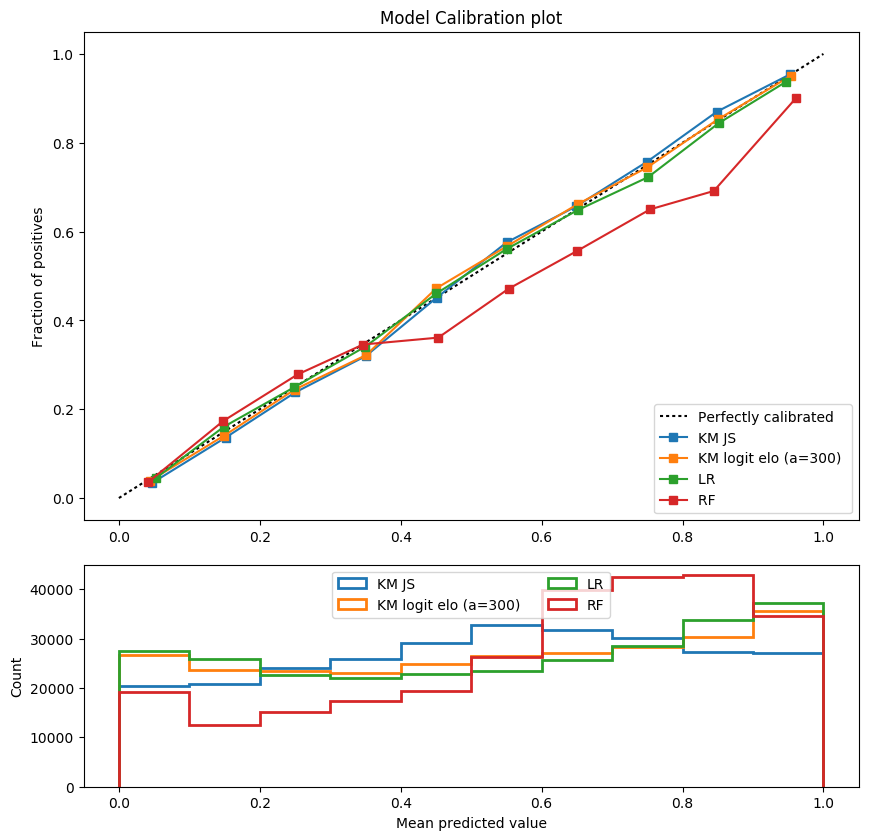

In [21]:
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

fig = plt.figure(0, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

models = [(test_df['klaassen_prob_JS'],'KM JS'),(test_df['klaassen_prob_a_300'],'KM logit elo (a=300)'), 
          (lr_probs_test,'LR'),(rf_probs,'RF')]
for col, name in models:
    a,b = calibration_curve(test_df['winner'], col, n_bins=1)
    print name, a[0]/b[0]
    frac_pos, mean_pred = calibration_curve(test_df['winner'], col, n_bins=10)
    ax1.plot(mean_pred, frac_pos, "s-", label="%s " % (name))
    ax2.hist(col, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
#ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Model Calibration plot')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
#plt.savefig('writing/photos/calibration_plot3')
plt.show()

In [36]:
a,b = calibration_curve(test_df['winner'], col, n_bins=1)
a[0]

0.53024821234419472

In [155]:
# # now, for surface
# columns = ['JS','elo','logit_elo','a_300']

# for col in columns:
#     print 'klaassen score '+col+' hard: ',log_loss(test_df['winner'][hard_ind],
#             test_df['klaassen_prob_'+col][hard_ind],labels=[0,1])
#     print 'klaassen score '+col+' clay: ',log_loss(test_df['winner'][clay_ind],
#             test_df['klaassen_prob_'+col][clay_ind],labels=[0,1])
#     print 'klaassen score '+col+' grass: ',log_loss(test_df['winner'][grass_ind],
#             test_df['klaassen_prob_'+col][grass_ind],labels=[0,1])

# print 'LR score '+col+' hard: ',log_loss(test_df['winner'][hard_ind],
#         test_df['lr_probs'][hard_ind],labels=[0,1])
# print 'LR score '+col+' clay: ',log_loss(test_df['winner'][clay_ind],
#         test_df['lr_probs'][clay_ind],labels=[0,1])
# print 'LR score '+col+' grass: ',log_loss(test_df['winner'][grass_ind],
#         test_df['lr_probs'][grass_ind],labels=[0,1])

# print 'RF score '+col+' hard: ',log_loss(test_df['winner'][hard_ind],
#         test_df['rf_probs'][hard_ind],labels=[0,1])
# print 'RF score '+col+' clay: ',log_loss(test_df['winner'][clay_ind],
#         test_df['rf_probs'][clay_ind],labels=[0,1])
# print 'RF score '+col+' grass: ',log_loss(test_df['winner'][grass_ind],
#         test_df['rf_probs'][grass_ind],labels=[0,1])

In [13]:
print 'klaassen score elo first set: ',log_loss(df['winner'][zero_set_ind],df['klaassen_prob_elo'][zero_set_ind],labels=[0,1])
#print 'klaassen score second set: ',log_loss(df['winner'][one_set_ind],df['klaassen_prob'][one_set_ind],labels=[0,1])
print 'klaassen score elo second set: ',log_loss(df['winner'][one_set_ind],df['klaassen_prob_elo'][one_set_ind],labels=[0,1])
#print 'klaassen score third set: ',log_loss(df['winner'][two_set_ind],df['klaassen_prob'][two_set_ind],labels=[0,1])
print 'klaassen score elo third set: ',log_loss(df['winner'][two_set_ind],df['klaassen_prob_elo'][two_set_ind],labels=[0,1])

klaassen score elo first set:  0.560927143892
klaassen score elo second set:  0.391126203129
klaassen score elo third set:  0.499848120888


In [13]:
#df

In [108]:
# include this in your analysis; the klaassen model is almost as bad at predicting in the third set 
# as it is in the first set (this should be improved with beta experiments)
print 'klaassen score first set: ',log_loss(df['winner'][zero_set_ind],df['klaassen_prob'][zero_set_ind],labels=[0,1])
print 'klaassen score JS first set: ',log_loss(df['winner'][zero_set_ind],df['klaassen_prob_JS'][zero_set_ind],labels=[0,1])
print 'klaassen score second set: ',log_loss(df['winner'][one_set_ind],df['klaassen_prob'][one_set_ind],labels=[0,1])
print 'klaassen score JS second set: ',log_loss(df['winner'][one_set_ind],df['klaassen_prob_JS'][one_set_ind],labels=[0,1])
print 'klaassen score third set: ',log_loss(df['winner'][two_set_ind],df['klaassen_prob'][two_set_ind],labels=[0,1])
print 'klaassen score JS third set: ',log_loss(df['winner'][two_set_ind],df['klaassen_prob_JS'][two_set_ind],labels=[0,1])

klaassen score first set:  0.526703165004
klaassen score JS first set:  0.538227097605
klaassen score second set:  0.379751243889
klaassen score JS second set:  0.385387382417
klaassen score third set:  0.509062169893
klaassen score JS third set:  0.512340971903


In [ ]:
# zero_index = df[df['winner']==0].index
# one_index = df[df['winner']==1].index

# best_prob = np.zeros(len(df))
# best_prob[zero_index] = np.minimum(df['klaassen_prob'][zero_index],df['klaassen_prob_JS'][zero_index])
# best_prob[one_index] = np.maximum(df['klaassen_prob'][one_index],df['klaassen_prob_JS'][one_index])
# df['best_prob'] = best_prob

In [95]:
# TO DO: provide the same breakdown by surface, surface and set...





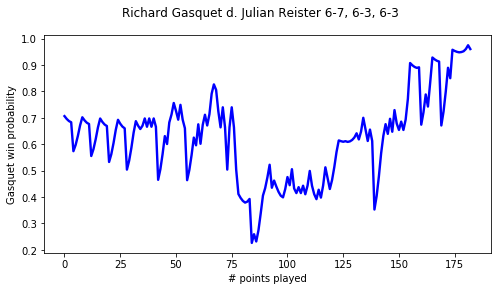

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

match1 = df[df['match_id']==1]
m1_probs = match1['klaassen_prob']
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m1_probs)),1-m1_probs,'b-',linewidth=2.4)
fig.suptitle('Richard Gasquet d. Julian Reister 6-7, 6-3, 6-3')
ax.set_ylabel('Gasquet win probability')
ax.set_xlabel('# points played')
#plt.savefig('gasquet_reister_7_14_all_features')
fig.show()

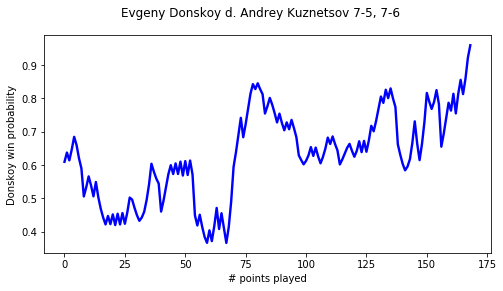

In [88]:
match2 = df[df['match_id']==2]
m2_probs = match2['klaassen_prob_a_400']
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m2_probs)),1-m2_probs,'b-',linewidth=2.4)
fig.suptitle('Evgeny Donskoy d. Andrey Kuznetsov 7-5, 7-6')
ax.set_ylabel('Donskoy win probability')
ax.set_xlabel('# points played')
fig.show()

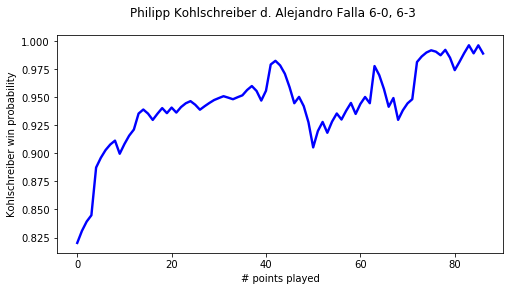

In [86]:
match5 = df[df['match_id']==4]
m5_probs = match5['klaassen_prob_a_400']
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m5_probs)),m5_probs,'b-',linewidth=2.4)
fig.suptitle('Philipp Kohlschreiber d. Alejandro Falla 6-0, 6-3')
ax.set_ylabel('Kohlschreiber win probability')
ax.set_xlabel('# points played')
fig.show()

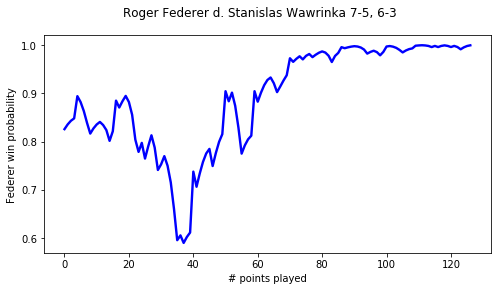

In [89]:
match10 = df[df['match_id']==10439]
m10_probs = match10['klaassen_prob_a_400']
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m10_probs)),m10_probs,'b-',linewidth=2.4)
fig.suptitle('Roger Federer d. Stanislas Wawrinka 7-5, 6-3')
ax.set_ylabel('Federer win probability')
ax.set_xlabel('# points played')
fig.show()

In [18]:
from sklearn.metrics import log_loss
# evaluate log_loss of these probabilities (log_loss(y_true,y_pred))
# we get .54 log_loss with no information about the players... (around .48 was best with most recent features)

# n=len(df)
# score = log_loss(df['winner'][:n],df['sackmann_prob'][:n],labels=[0,1])
# print 'sackmann score: ',score

k_df = df[df['klaassen_prob']==df['klaassen_prob']]
k_score = log_loss(k_df['winner'][:n],k_df['klaassen_prob'][:n],labels=[0,1])
print 'klaassen score: ',k_score
#df.to_csv('../my_data/feature_df_pbp3_7_30_s_prob.csv')

sackmann score:  0.538905529928
klaassen score:  0.591980500589


In [ ]:
# when we don't use a prior, or assign weights to evidence, we get serving percentages like this one...
# Tursunov's 25/32 return percentage was way the hell too high
df['match_id'][760117],df['p0_s_kls'][760117]

In [ ]:
# use group K-fold to preserve separation of matches
def pbp_validate_results(df,probs,lm_columns,n_splits=5):
    groups = df.match_id
    group_kfold = KFold(n_splits=n_splits,shuffle=True)
    scores = np.zeros([len(lm_columns)+len(probs),2,n_splits]);i=0
    for train_ind,test_ind in group_kfold.split(df,groups):
        lm = linear_model.LogisticRegression(fit_intercept = True)
        train_df,test_df = df.loc[train_ind],df.loc[test_ind]
        
        for j,prob_col in enumerate(probs):
            y_preds = test_df[prob_col]>.5
            scores[j][0][i]=accuracy_score(test_df['winner'],y_preds)
            scores[j][1][i]=log_loss(test_df['winner'],test_df[prob_col],labels=[0,1])
        
        for k,cols in enumerate(lm_columns):
            lm.fit(train_df[cols].values.reshape([len(train_df),len(cols)]),train_df['winner'])
            y_preds = lm.predict(test_df[cols].values.reshape([len(test_df),len(cols)]))
            y_probs = lm.predict_proba(test_df[cols].values.reshape([len(test_df),len(cols)]))
            scores[len(probs)+k][0][i]=accuracy_score(test_df['winner'],y_preds)
            scores[len(probs)+k][1][i]=log_loss(test_df['winner'],y_probs,labels=[0,1])
        i+=1

    for j,prob_col in enumerate(probs):
        print prob_col
        print 'accuracy: ', np.mean(scores[j][0])
        print 'loss: ', np.mean(scores[j][1])
    
    for i,cols in enumerate(lm_columns):
        print 'lm columns: ',cols
        print 'accuracy: ', np.mean(scores[len(probs)+i][0])
        print 'loss: ', np.mean(scores[len(probs)+i][1])

In [24]:
from sklearn.metrics import log_loss,accuracy_score

n = len(df)

# a=400 works the best
# print 'sackmann score: ',log_loss(df['winner'][:n],df['sackmann_prob'][:n],labels=[0,1]),\
#         accuracy_score(df['winner'][:n],df['sackmann_prob'][:n]>=.5)
# print 'klaassen score: ',log_loss(df['winner'][:n],df['klaassen_prob'][:n],labels=[0,1]),\
#         accuracy_score(df['winner'][:n],df['klaassen_prob'][:n]>=.5)
print 'klaassen score JS: ',log_loss(df['winner'][:n],df['klaassen_prob_JS'][:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],df['klaassen_prob_JS'][:n]>=.5)
# print 'klaassen score adj: ',log_loss(df['winner'][:n],df['klaassen_prob_adj'][:n],labels=[0,1]),\
#         accuracy_score(df['winner'][:n],df['klaassen_prob_adj'][:n]>=.5)
print 'klaassen score adj JS: ',log_loss(df['winner'][:n],df['klaassen_prob_adj_JS'][:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],df['klaassen_prob_adj_JS'][:n]>=.5)
print 'klaassen score elo: ',log_loss(df['winner'][:n],df['klaassen_prob_elo'][:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],df['klaassen_prob_elo'][:n]>=.5)
print 'klaassen score logit elo: ',log_loss(df['winner'][:n],df['klaassen_prob_logit_elo'][:n],labels=[0,1]),\
        accuracy_score(df['winner'][:n],df['klaassen_prob_logit_elo'][:n]>=.5)
# print 'best score of both: ',log_loss(df['winner'][:n],best_prob[:n],labels=[0,1]),\
#         accuracy_score(df['winner'][:n],best_prob[:n]>=.5)

alphas = [1,10,100,200,300,400,500,600,1000]
for alpha in alphas:
    print 'klaassen score, a='+str(alpha)+': ',log_loss(df['winner'][:n],
           df['klaassen_prob_a_'+str(alpha)][:n],labels=[0,1]), \
           accuracy_score(df['winner'][:n],df['klaassen_prob_a_'+str(alpha)][:n]>=.5)

klaassen score JS:  0.501757939762 0.748687459588
klaassen score adj JS:  0.501403005326 0.755023675257
klaassen score elo:  0.486423301368 0.761185185719
klaassen score logit elo:  0.481827714317 0.763661677062
klaassen score, a=1:  0.934724861709 0.717937541988
klaassen score, a=10:  0.620111398016 0.732063448609
klaassen score, a=100:  0.482528897633 0.760556607189
klaassen score, a=200:  0.478337183192 0.763443745824
klaassen score, a=300:  0.478253828778 0.764335282707
klaassen score, a=400:  0.478597551707 0.764515391169
klaassen score, a=500:  0.478954433083 0.764637864922
klaassen score, a=600:  0.47926289092 0.76467208553
klaassen score, a=1000:  0.480068692898 0.764358696807


In [ ]:
# import pandas as pd
# import numpy as np

# # get id of matches we want to display
# df_b = pd.read_csv('../my_data/feature_df_pbp5_10_15_probs.csv')
# m_id1 = 10667
# m_id2 = 836

# import matplotlib.pyplot as plt
# %matplotlib inline

# match1 = df_b[df_b['match_id']==m_id1]
# m1_probs = match1['klaassen_prob_a_300']
# fig = plt.figure(figsize=(8,4))
# ax = fig.add_subplot(1,1,1)
# ax.plot(np.arange(len(m1_probs)),1-m1_probs,'b-',linewidth=2.4)
# fig.suptitle('Roger Federer d. Rafael Nadal 6-3 3-6 6-1 3-6 6-3')
# ax.set_ylabel('Federer win probability')
# ax.set_xlabel('# points played')
# ax.set_ylim([0,1])
# plt.savefig('writing/photos/federer_nadal_ao_17')
# #fig.show()

# match1 = df_b[df_b['match_id']==m_id2]
# m1_probs = match1['klaassen_prob_a_300']
# fig = plt.figure(figsize=(8,4))
# ax = fig.add_subplot(1,1,1)
# ax.plot(np.arange(len(m1_probs)),1-m1_probs,'b-',linewidth=2.4)
# fig.suptitle('Novak Djokovic d. Roger Federer 6-7 4-6 6-3 6-2 7-5')
# ax.set_ylabel('Djokovic win probability')
# ax.set_xlabel('# points played')
# ax.set_ylim([0,1])
# plt.savefig('writing/photos/djokovic_federer_uso_11')
# #fig.show()